<a href="https://colab.research.google.com/github/blueberricheesecake/Bank-Churn/blob/main/Bank_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importing Libraries

In [1]:
!pip install -U autogluon > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
bigframes 0.26.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.1.4 which is incompatible.
cvxpy 1.3.3 requires setuptools>65.5.1, but you have setuptools 60.2.0 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.4 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.28.2 which is incompatible.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 2.0.1 which is incompatible.
torchtext 0.17.1 requires torch==2.2.1, but you have torch 2.0.1 which is incompatible.
yfinance 0.2.37 requires requests>=2.31, but you have requests 2.28.2 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

###Data Preprocessing and EDA

In [3]:
data_train_url = "https://raw.githubusercontent.com/Rajvir0712/BankChurn_Data/main/train-3.csv"
data_test_url = "https://raw.githubusercontent.com/Rajvir0712/BankChurn_Data/main/test-2.csv"
data_churn_url = "https://raw.githubusercontent.com/Rajvir0712/BankChurn_Data/main/Churn_Modelling.csv"
df_train = pd.read_csv(data_train_url)
df_test = pd.read_csv(data_test_url)
df_churn = pd.read_csv(data_churn_url)

In [4]:
df_churn.rename(columns = {'RowNumber':'id'}, inplace = True)

In [5]:
df_train = pd.concat([df_train, df_churn], ignore_index=True)

In [6]:
df_train.drop_duplicates()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175029,9996,15606229,Obijiaku,771,France,Male,39.0,5,0.00,2,1.0,0.0,96270.64,0
175030,9997,15569892,Johnstone,516,France,Male,35.0,10,57369.61,1,1.0,1.0,101699.77,0
175031,9998,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
175032,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1


In [7]:
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [8]:
df_train['Products_Per_Tenure'] =  df_train['Tenure'] / df_train['NumOfProducts']
df_test['Products_Per_Tenure'] =  df_test['Tenure'] / df_test['NumOfProducts']

In [9]:
df_train['IsActive_by_CreditCard'] = df_train['HasCrCard'] * df_train['IsActiveMember']
df_test['IsActive_by_CreditCard'] = df_test['HasCrCard'] * df_test['IsActiveMember']

In [10]:
df_train['QualityOfBalance'] = pd.cut(df_train['Balance'], bins=[-1,100,1000,10000,50000,1000000], labels=['VeryLow', 'Low', 'Medium','High','Highest'])
df_train['QualityOfBalance'].replace(['VeryLow', 'Low', 'Medium','High','Highest'],[0,1,2,3,4], inplace=True)

df_test['QualityOfBalance'] = pd.cut(df_test['Balance'], bins=[-1,100,1000,10000,50000,1000000], labels=['VeryLow', 'Low', 'Medium','High','Highest'])
df_test['QualityOfBalance'].replace(['VeryLow', 'Low', 'Medium','High','Highest'],[0,1,2,3,4], inplace=True)

In [11]:
df_train['Customer_Status'] = df_train['Tenure'].apply(lambda x:0 if x < 2 else 1)
df_test['Customer_Status'] = df_test['Tenure'].apply(lambda x:0 if x < 2 else 1)
df_train['Balance_to_Salary_Ratio'] = df_train['Balance'] / df_train['EstimatedSalary']
df_test['Balance_to_Salary_Ratio'] = df_test['Balance'] / df_test['EstimatedSalary']


In [12]:
#Checked and no null values
print(df_train['Exited'].value_counts(normalize=True))

Exited
0    0.788852
1    0.211148
Name: proportion, dtype: float64


In [13]:
print(df_train['Geography'].value_counts(normalize=True))

Geography
France     0.566913
Spain      0.221043
Germany    0.212045
Name: proportion, dtype: float64


In [14]:
print(df_train['NumOfProducts'].value_counts(normalize=True))

NumOfProducts
2    0.507793
1    0.471097
3    0.018054
4    0.003057
Name: proportion, dtype: float64


In [15]:


# Create the new feature in the training data
df_train['Geo_Gender'] = df_train['Geography'] + '_' + df_train['Gender']

# Create the new feature in the testing data
df_test['Geo_Gender'] = df_test['Geography'] + '_' + df_test['Gender']

# Now, both df_train and df_test have the new 'Geo_Gender' feature
# You might want to check the first few rows to see the new feature
#print(df_train.head())


In [16]:
# Convert numeric columns to strings and then concatenate
df_train['AGE_SCORE'] = df_train['Age'].astype(str) + '_' + df_train['CreditScore'].astype(str)
df_test['AGE_SCORE'] = df_test['Age'].astype(str) + '_' + df_test['CreditScore'].astype(str)

# Now, both df_train and df_test have the new 'AGE_SCORE' feature
print(df_train.head())


   id  CustomerId         Surname  CreditScore Geography Gender   Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male  33.0       3   
1   1    15749177   Okwudiliolisa          627    France   Male  33.0       1   
2   2    15694510           Hsueh          678    France   Male  40.0      10   
3   3    15741417             Kao          581    France   Male  34.0       2   
4   4    15766172       Chiemenam          716     Spain   Male  33.0       5   

     Balance  NumOfProducts  ...  IsActiveMember  EstimatedSalary  Exited  \
0       0.00              2  ...             0.0        181449.97       0   
1       0.00              2  ...             1.0         49503.50       0   
2       0.00              2  ...             0.0        184866.69       0   
3  148882.54              1  ...             1.0         84560.88       0   
4       0.00              2  ...             1.0         15068.83       0   

   Products_Per_Tenure  IsActive_by_CreditCard  Qu

In [17]:
# One-hot encoding the 'NumOfProducts' column
df_train = pd.get_dummies(df_train, columns=['NumOfProducts'])
df_test = pd.get_dummies(df_test, columns=['NumOfProducts'])

In [18]:
# One-hot encoding the 'Geography' column
df_train = pd.get_dummies(df_train, columns=['Geography'])
df_test = pd.get_dummies(df_test, columns=['Geography'])

In [19]:
# One-hot encoding the 'Geography' column
df_train = pd.get_dummies(df_train, columns=['Gender'])
df_test = pd.get_dummies(df_test, columns=['Gender'])

In [20]:
df_train.head()

,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,...,AGE_SCORE,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0,15674932,Okwudilichukwu,668,33.0,3,0.00,1.0,0.0,181449.97,...,33.0_668,False,True,False,False,True,False,False,False,True
1,1,15749177,Okwudiliolisa,627,33.0,1,0.00,1.0,1.0,49503.50,...,33.0_627,False,True,False,False,True,False,False,False,True
2,2,15694510,Hsueh,678,40.0,10,0.00,1.0,0.0,184866.69,...,40.0_678,False,True,False,False,True,False,False,False,True
3,3,15741417,Kao,581,34.0,2,148882.54,1.0,1.0,84560.88,...,34.0_581,True,False,False,False,True,False,False,False,True
4,4,15766172,Chiemenam,716,33.0,5,0.00,1.0,1.0,15068.83,...,33.0_716,False,True,False,False,False,False,True,False,True


In [21]:
df_test.head()

,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,...,AGE_SCORE,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,165034,15773898,Lucchese,586,23.0,2,0.00,0.0,1.0,160976.75,...,23.0_586,False,True,False,False,True,False,False,True,False
1,165035,15782418,Nott,683,46.0,2,0.00,1.0,0.0,72549.27,...,46.0_683,True,False,False,False,True,False,False,True,False
2,165036,15807120,K?,656,34.0,7,0.00,1.0,0.0,138882.09,...,34.0_656,False,True,False,False,True,False,False,True,False
3,165037,15808905,O'Donnell,681,36.0,8,0.00,1.0,0.0,113931.57,...,36.0_681,True,False,False,False,True,False,False,False,True
4,165038,15607314,Higgins,752,38.0,10,121263.62,1.0,0.0,139431.00,...,38.0_752,True,False,False,False,False,True,False,False,True


In [22]:
mean_tenure = df_train['Tenure'].mean()

print("Mean Tenure:", mean_tenure)

Mean Tenure: 5.01992184375607


In [23]:
mean_tenure = df_train['Tenure'].median()

print("Median Tenure:", mean_tenure)


Median Tenure: 5.0


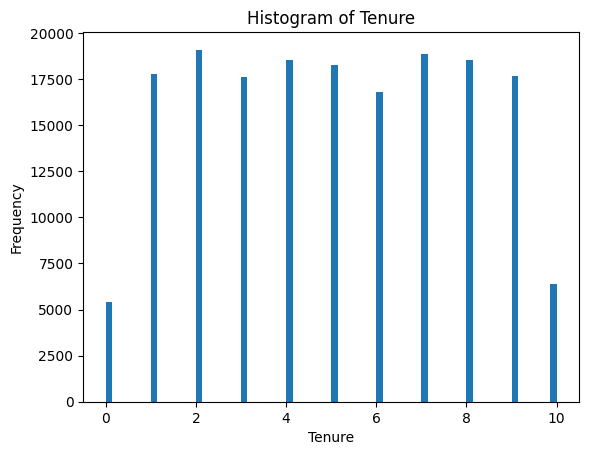

In [24]:
# Assuming 'df' is your DataFrame
plt.hist(df_train['Tenure'], bins='auto')  # 'auto' selects an optimal number of bins
plt.xlabel('Tenure')
plt.ylabel('Frequency')
plt.title('Histogram of Tenure')
plt.show()


In [25]:
bins = [0, 3.32, 6.67, df_train['Tenure'].max() + 0.01]
labels = ['Low Tenure', 'Medium Tenure', 'High Tenure']
df_train['TenureGroup'] = pd.cut(df_train['Tenure'], bins=bins, labels=labels, include_lowest=True)
print(df_train[['Tenure', 'TenureGroup']])

        Tenure    TenureGroup
0            3     Low Tenure
1            1     Low Tenure
2           10    High Tenure
3            2     Low Tenure
4            5  Medium Tenure
...        ...            ...
175029       5  Medium Tenure
175030      10    High Tenure
175031       7    High Tenure
175032       3     Low Tenure
175033       4  Medium Tenure

[175034 rows x 2 columns]


In [26]:
bins = [0, 3.32, 6.67, df_train['Tenure'].max() + 0.01]
labels = ['Low Tenure', 'Medium Tenure', 'High Tenure']
df_test['TenureGroup'] = pd.cut(df_test['Tenure'], bins=bins, labels=labels, include_lowest=True)
print(df_test[['Tenure', 'TenureGroup']])

        Tenure    TenureGroup
0            2     Low Tenure
1            2     Low Tenure
2            7    High Tenure
3            8    High Tenure
4           10    High Tenure
...        ...            ...
110018       7    High Tenure
110019       4  Medium Tenure
110020       2     Low Tenure
110021       3     Low Tenure
110022       7    High Tenure

[110023 rows x 2 columns]


In [27]:
df_train.head()

,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,...,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,TenureGroup
0,0,15674932,Okwudilichukwu,668,33.0,3,0.00,1.0,0.0,181449.97,...,False,True,False,False,True,False,False,False,True,Low Tenure
1,1,15749177,Okwudiliolisa,627,33.0,1,0.00,1.0,1.0,49503.50,...,False,True,False,False,True,False,False,False,True,Low Tenure
2,2,15694510,Hsueh,678,40.0,10,0.00,1.0,0.0,184866.69,...,False,True,False,False,True,False,False,False,True,High Tenure
3,3,15741417,Kao,581,34.0,2,148882.54,1.0,1.0,84560.88,...,True,False,False,False,True,False,False,False,True,Low Tenure
4,4,15766172,Chiemenam,716,33.0,5,0.00,1.0,1.0,15068.83,...,False,True,False,False,False,False,True,False,True,Medium Tenure


In [28]:
contingency_table = pd.crosstab(df_train['TenureGroup'], df_train['Exited'])

# Perform the Chi-Squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Squared: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected frequencies:")
print(expected)


Chi-Squared: 72.88862608869348
P-value: 1.487427984609825e-16
Degrees of Freedom: 2
Expected frequencies:
[[47289.33791149 12657.66208851]
 [42291.95763109 11320.04236891]
 [48494.70445742 12980.29554258]]


In [29]:
def age_tr(df) :
    df['Age_Category'] = pd.cut(df['Age'], bins=[18, 30, 40, 50, 60, 100], labels=['18-30', '30-40', '40-50', '50-60', '60+'],include_lowest = True)
    return df

df_train = age_tr(df_train)
df_test = age_tr(df_test)


In [30]:
df_train.head()

,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,...,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,TenureGroup,Age_Category
0,0,15674932,Okwudilichukwu,668,33.0,3,0.00,1.0,0.0,181449.97,...,True,False,False,True,False,False,False,True,Low Tenure,30-40
1,1,15749177,Okwudiliolisa,627,33.0,1,0.00,1.0,1.0,49503.50,...,True,False,False,True,False,False,False,True,Low Tenure,30-40
2,2,15694510,Hsueh,678,40.0,10,0.00,1.0,0.0,184866.69,...,True,False,False,True,False,False,False,True,High Tenure,30-40
3,3,15741417,Kao,581,34.0,2,148882.54,1.0,1.0,84560.88,...,False,False,False,True,False,False,False,True,Low Tenure,30-40
4,4,15766172,Chiemenam,716,33.0,5,0.00,1.0,1.0,15068.83,...,True,False,False,False,False,True,False,True,Medium Tenure,30-40


In [31]:
# One-hot encoding the 'NumOfProducts' column
df_train = pd.get_dummies(df_train, columns=['Age_Category'])
df_test = pd.get_dummies(df_test, columns=['Age_Category'])

In [32]:
# One-hot encoding the 'NumOfProducts' column
df_train = pd.get_dummies(df_train, columns=['TenureGroup'])
df_test = pd.get_dummies(df_test, columns=['TenureGroup'])

In [33]:
# Assuming the range of EstimatedSalary is from 0 to 200000 as per the histogram
bin_edges = [0, 20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000]
bin_labels = ['0-20k', '20-40k', '40-60k', '60-80k', '80-100k', '100-120k', '120-140k', '140-160k', '160-180k', '180-200k']

# Applying binning to the DataFrame
df_train['SalaryBin_Custom'] = pd.cut(df_train['EstimatedSalary'], bins=bin_edges, labels=bin_labels)


# Now the DataFrame 'df' has additional columns with the binned data


In [34]:
# Assuming the range of EstimatedSalary is from 0 to 200000 as per the histogram
bin_edges = [0, 20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000]
bin_labels = ['0-20k', '20-40k', '40-60k', '60-80k', '80-100k', '100-120k', '120-140k', '140-160k', '160-180k', '180-200k']

# Applying binning to the DataFrame
df_test['SalaryBin_Custom'] = pd.cut(df_test['EstimatedSalary'], bins=bin_edges, labels=bin_labels)


In [35]:
# One-hot encode the 'SalaryBin_Custom' column if it has not been done yet
df_train = pd.get_dummies(df_train, columns=['SalaryBin_Custom'])
# One-hot encode the 'SalaryBin_Custom' column if it has not been done yet
df_test = pd.get_dummies(df_test, columns=['SalaryBin_Custom'])


In [36]:
import pandas as pd

def cred_score_tr(df):
    bins = list(range(350, 851, 50))
    labels = [f'{i}-{i+49}' for i in bins[:-1]]

    df['Credit_Score_Range'] = pd.cut(df['CreditScore'], bins=bins, labels=labels, include_lowest=True)
    df['Credit_Score_Range'] = df['Credit_Score_Range'].astype('object')
    return df

# Apply the function to both training and testing data
df_train = cred_score_tr(df_train)
df_test = cred_score_tr(df_test)




In [37]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175034 entries, 0 to 175033
Data columns (total 46 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   id                         175034 non-null  int64   
 1   CustomerId                 175034 non-null  int64   
 2   Surname                    175034 non-null  object  
 3   CreditScore                175034 non-null  int64   
 4   Age                        175034 non-null  float64 
 5   Tenure                     175034 non-null  int64   
 6   Balance                    175034 non-null  float64 
 7   HasCrCard                  175034 non-null  float64 
 8   IsActiveMember             175034 non-null  float64 
 9   EstimatedSalary            175034 non-null  float64 
 10  Exited                     175034 non-null  int64   
 11  Products_Per_Tenure        175034 non-null  float64 
 12  IsActive_by_CreditCard     175034 non-null  float64 
 13  QualityOfBalan

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Assuming df_train is your training DataFrame
X = df_train.drop('Exited', axis=1)  # Features
y = df_train['Exited']               # Target
X_encoded = pd.get_dummies(X)

# Parameter grid for RandomizedSearch
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4],
    'gamma': [i/10.0 for i in range(0, 5)],
    'subsample': [i/10.0 for i in range(6, 10)],
    'colsample_bytree': [i/10.0 for i in range(6, 10)],
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
    'scale_pos_weight': [i/10.0 for i in range(1, 10)],
    'alpha': [1e-5, 1e-2, 0.1, 1, 100]
}

# Set up the random search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(),
    param_distributions=param_grid,
    n_iter=100,  # Number of parameter settings sampled
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5),
    verbose=3,
    random_state=42,
    n_jobs=1  # Use all available cores
)

# Fit the random search model
random_search.fit(X_encoded, y)

# Best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best AUC score found: ", random_search.best_score_)

# Retrain the model with the best parameters found
best_params = random_search.best_params_
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_encoded, y)

# Continue with your test predictions and submission as before...


Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
# Assuming df_test is your test DataFrame and it has been preprocessed similarly to df_train
df_test_encoded = pd.get_dummies(df_test)
df_test_encoded = df_test_encoded.reindex(columns=X_encoded.columns, fill_value=0)

# Make predictions on the test dataset
test_pred_proba = final_model.predict_proba(df_test_encoded)[:, 1]

# Create a submission DataFrame
# Ensure 'id' matches the name of the identifier column in your test dataset
submission_df = pd.DataFrame({
    'id': df_test['id'],
    'Exited': test_pred_proba
})

# Save the submission file
submission_filename = 'xgboost_submission_2.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"Submission file '{submission_filename}' created successfully.")

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Assuming df_train is your training DataFrame
X = df_train.drop('Exited', axis=1)  # Features
y = df_train['Exited']               # Target
X_encoded = pd.get_dummies(X)

xgb_params = {'alpha': 2.1401971831451174e-07,
                           'subsample': 0.8154621328436412,
                           'colsample_bytree': 0.6993225521103127,
                           'max_depth': 6,
                           'min_child_weight': 3,
                           'learning_rate': 0.09326219307123645,
                           'gamma': 0.0035058360119452673,
                           'scale_pos_weight': 0.81619438771}

# Train initial model to get feature importances
initial_model = xgb.XGBClassifier(**xgb_params)  # Use your existing parameters
initial_model.fit(X_encoded, y)

# Get feature importances and sort them
feature_importances = initial_model.feature_importances_
features = np.array(X_encoded.columns)
sorted_idx = np.argsort(feature_importances)[::-1]

# Cross-validation settings
kfold = StratifiedKFold(n_splits=5)
scores = []

# Evaluate performance with incremental feature addition
for i in range(1, len(features) + 1):
    selected_features = features[sorted_idx][:i]
    X_selected = X_encoded[selected_features]
    score = np.mean(cross_val_score(initial_model, X_selected, y, cv=kfold, scoring='roc_auc'))
    scores.append(score)
    print(f"Score with {i} features: {score}")

# Find the number of features that gives the best score
optimal_n = np.argmax(scores) + 1  # Adding 1 because index starts from 0
print(f"Optimal number of features: {optimal_n}")

# Now you can retrain your model with the optimal number of features
optimal_features = features[sorted_idx][:optimal_n]
X_optimal = X_encoded[optimal_features]
final_model = xgb.XGBClassifier(**xgb_params)
final_model.fit(X_optimal, y)

# Continue with your model evaluation or predictions...


In [ ]:
import pandas as pd
import xgboost as xgb

# Assuming df_train and df_test are your training and test DataFrames
X_train = df_train.drop('Exited', axis=1)  # Features from training set
y_train = df_train['Exited']               # Target from training set
X_test = df_test                           # Features from test set

# Encode categorical variables if necessary (as done previously)
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Retrain the model with optimal features
optimal_features = features[sorted_idx][:optimal_n]  # optimal_n and sorted_idx from previous steps
X_train_optimal = X_train_encoded[optimal_features]
X_test_optimal = X_test_encoded.reindex(columns=optimal_features, fill_value=0)

final_model = xgb.XGBClassifier(**xgb_params)  # Use the optimal parameters
final_model.fit(X_train_optimal, y_train)

# Make predictions on the test dataset
test_pred_proba = final_model.predict_proba(X_test_optimal)[:, 1]

# Create a submission DataFrame
# Replace 'id' with the name of the identifier column in your test dataset
submission_df = pd.DataFrame({
    'id': df_test['id'],  # Ensure this matches your test data's identifier column
    'Exited': test_pred_proba
})

# Save the submission file
submission_filename = 'xgboost_optimal_features_submission.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"Submission file '{submission_filename}' created successfully.")


In [ ]:
# Retrain the model on the entire training dataset

import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Preparing data
X = df_train.drop('Exited', axis=1)  # Features
y = df_train['Exited']               # Target
X_encoded = pd.get_dummies(X)


xgb_params = {'alpha': 2.1401971831451174e-07,
                           'subsample': 0.8154621328436412,
                           'colsample_bytree': 0.6993225521103127,
                           'max_depth': 6,
                           'min_child_weight': 3,
                           'learning_rate': 0.09326219307123645,
                           'gamma': 0.0035058360119452673,
                           'scale_pos_weight': 0.81619438771}

final_model = xgb.XGBClassifier(**xgb_params)
final_model.fit(X_encoded, y)

# Assuming df_test is your test DataFrame and it has been preprocessed similarly to df_train
df_test_encoded = pd.get_dummies(df_test)
df_test_encoded = df_test_encoded.reindex(columns=X_encoded.columns, fill_value=0)

# Make predictions on the test dataset
test_pred_proba = final_model.predict_proba(df_test_encoded)[:, 1]

# Create a submission DataFrame
# Ensure 'id' matches the name of the identifier column in your test dataset
submission_df = pd.DataFrame({
    'id': df_test['id'],
    'Exited': test_pred_proba
})

# Save the submission file
submission_filename = 'xgboost_submission_1.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"Submission file '{submission_filename}' created successfully.")


In [ ]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Preparing data
X = df_train.drop('Exited', axis=1)  # Features
y = df_train['Exited']               # Target

# Encoding categorical variables (if not already done)
X_encoded = pd.get_dummies(X)

# Splitting data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


xgb_simple_params = {'alpha': 2.1401971831451174e-07,
                           'subsample': 0.8154621328436412,
                           'colsample_bytree': 0.6993225521103127,
                           'max_depth': 10,
                           'min_child_weight': 3,
                           'learning_rate': 0.09326219307123645,
                           'gamma': 0.0035058360119452673,
                           'scale_pos_weight': 0.8161943877125253}
# Initialize XGBoost classifier with specified parameters
xgb_clf = xgb.XGBClassifier(**xgb_simple_params, use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_clf.fit(X_train, y_train)

# Predict probabilities for the validation set
y_pred_proba = xgb_clf.predict_proba(X_val)[:,1]

# Calculate AUC score
auc_score = roc_auc_score(y_val, y_pred_proba)
print(f"AUC Score: {auc_score}")

# Encoding categorical variables in test data (if not already done)
df_test_encoded = pd.get_dummies(df_test)

# Aligning test data columns with training data
df_test_encoded = df_test_encoded.reindex(columns = X_train.columns, fill_value=0)

# Predict probabilities for test data
test_pred_proba = xgb_clf.predict_proba(df_test_encoded)[:, 1]

# Create a DataFrame with IDs and predicted probabilities
submission_df = pd.DataFrame({
    'id': df_test['id'],  # Using 'id' as the identifier from your test data
    'Exited': test_pred_proba
})

# Display the first few rows of the submission file
print(submission_df.head())

# Save the submission file
submission_df.to_csv('submission.csv', index=False)


In [ ]:
df_train.info()

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [ ]:
train = TabularDataset(df_train)
test = TabularDataset(df_test)

automl = TabularPredictor(label='Exited', problem_type='binary', eval_metric='roc_auc')
automl.fit(train, presets='best_quality')

In [ ]:
automl.leaderboard()

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

# Load your trained AutoML model
# Make sure the path is where your AutoGluon model is saved
predictor = TabularPredictor.load("AutogluonModels/ag-20240114_105858")

# Identify the best model from the leaderboard
best_model = predictor.get_model_best()

# Load your test data
# Assuming df_test is your test DataFrame and it contains an 'id' column
df_test_encoded = pd.get_dummies(df_test)
df_test_encoded = df_test_encoded.reindex(columns = predictor.feature_metadata_in.get_features(), fill_value=0)

# Make predictions using the best model
# If your task requires probabilities, use `predict_proba`
predictions = predictor.predict_proba(df_test_encoded, model=best_model)[:, 1]

# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'id': df_test['id'],  # Replace 'id' with the actual ID column name from your test dataset
    'Exited': predictions  # This column should be named as per the submission requirements
})

# Save the submission file
submission_df.to_csv('autogluon_submission.csv', index=False)

# Display the first few rows of the submission file
print(submission_df.head())







In [ ]:
df_train.head()

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

# Load your trained AutoML model
predictor = TabularPredictor.load("AutogluonModels/ag-20240114_124036")

# Identify the best model from the leaderboard
best_model = predictor.get_model_best()

# Load your test data
df_test_encoded = pd.get_dummies(df_test)
df_test_encoded = df_test_encoded.reindex(columns = predictor.feature_metadata_in.get_features(), fill_value=0)

# Make predictions using the best model
predictions_proba = predictor.predict_proba(df_test_encoded, model=best_model)

# Extract the probabilities for the positive class
# Assuming binary classification, the positive class is usually at index 1
positive_class_probabilities = predictions_proba.iloc[:, 1]

# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'id': df_test['id'],  # Make sure 'id' matches the ID column name in your test dataset
    'Exited': positive_class_probabilities
})

# Save the submission file
submission_df.to_csv('autogluon_submission.csv', index=False)

# Display the first few rows of the submission file
print(submission_df.head())
